<a href="https://colab.research.google.com/github/thesimaranjaira/AspectExtraction_SentimentAnalysis/blob/main/SARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
perHome= (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 0])
perHome

timestamp
2018-08-13 01:00:00    1.167373
2018-08-13 02:00:00    1.171019
2018-08-13 03:00:00    1.102508
2018-08-13 04:00:00    1.281203
2018-08-13 05:00:00    1.562144
                         ...   
2021-01-28 18:00:00    4.518195
2021-01-28 19:00:00    4.527884
2021-01-28 20:00:00    4.448015
2021-01-28 21:00:00    4.299834
2021-01-28 22:00:00    4.110891
Name: consumption, Length: 21598, dtype: float64

In [5]:
totalConsumption = (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 2])
totalConsumption

timestamp
2018-08-13 01:00:00      3190.430
2018-08-13 02:00:00      3200.395
2018-08-13 03:00:00      3013.154
2018-08-13 04:00:00      3501.527
2018-08-13 05:00:00      4269.340
                          ...    
2021-01-28 18:00:00    180122.345
2021-01-28 19:00:00    180508.608
2021-01-28 20:00:00    177324.554
2021-01-28 21:00:00    171417.187
2021-01-28 22:00:00    163884.793
Name: consumptiontotal, Length: 21598, dtype: float64

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
      
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

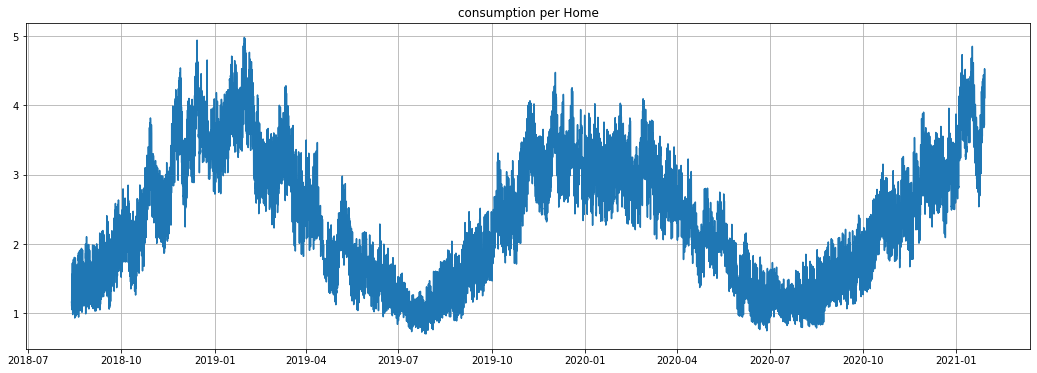

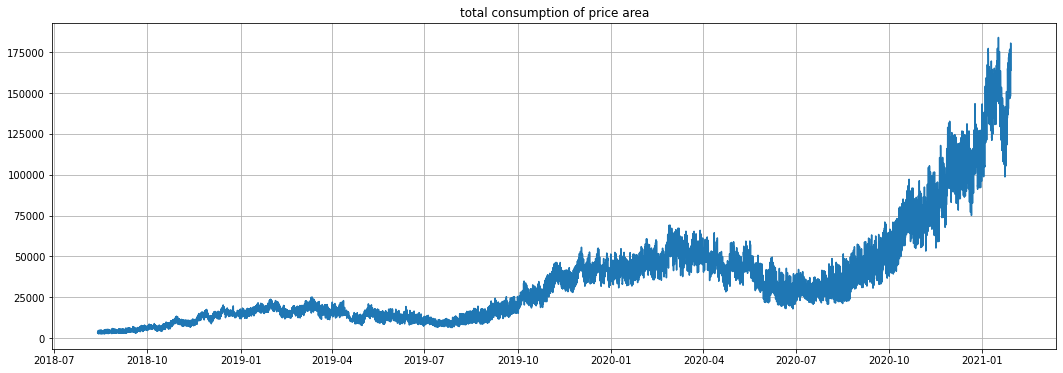

In [7]:
plt.figure(figsize=(18, 6))
plt.plot(perHome)
plt.title('consumption per Home')
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(totalConsumption)
plt.title('total consumption of price area')
plt.grid(True)
plt.show()

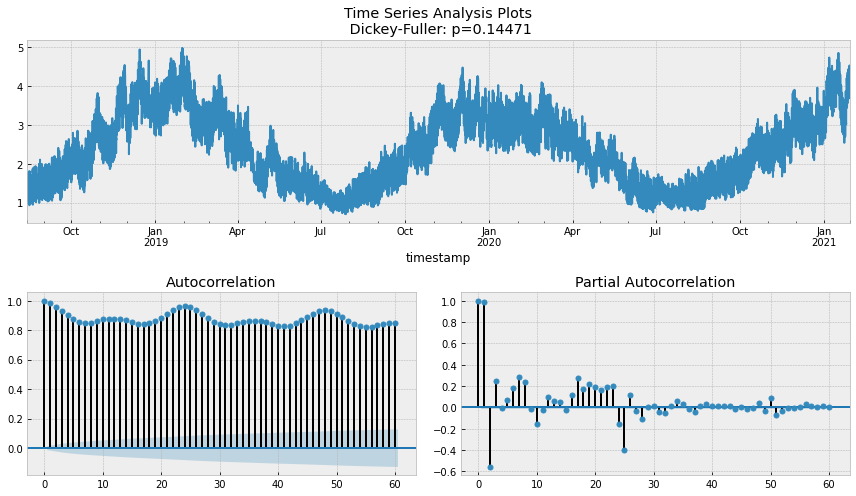

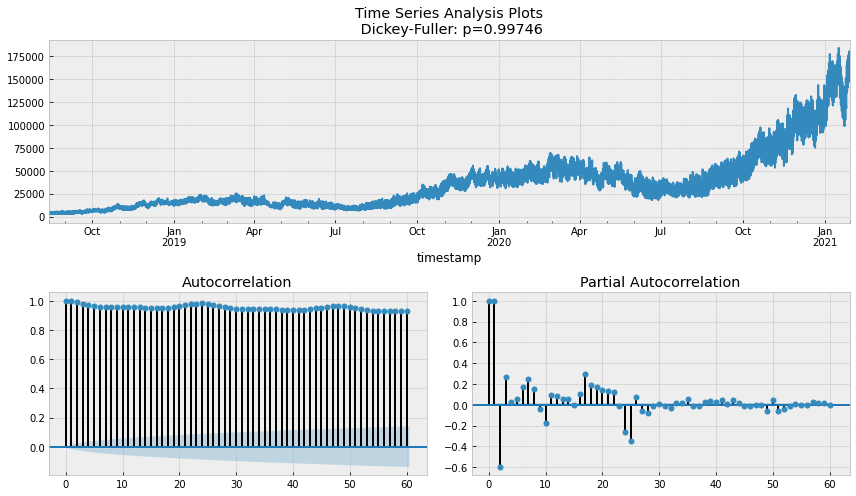

In [8]:
tsplot(perHome, lags=60)
tsplot(totalConsumption, lags=60) #since the consumption is not normalized, it's not clear if i should use total consumption??????

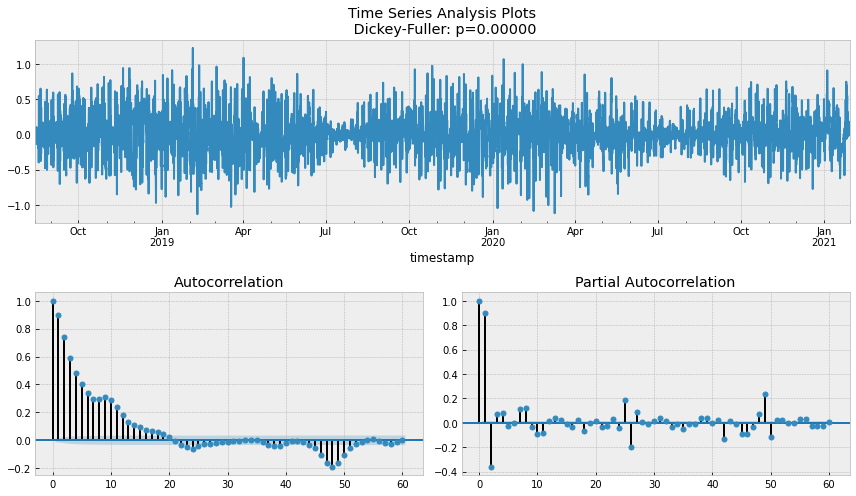

In [10]:
per_diff = perHome - perHome.shift(24)
tsplot(per_diff[24:], lags=60) 

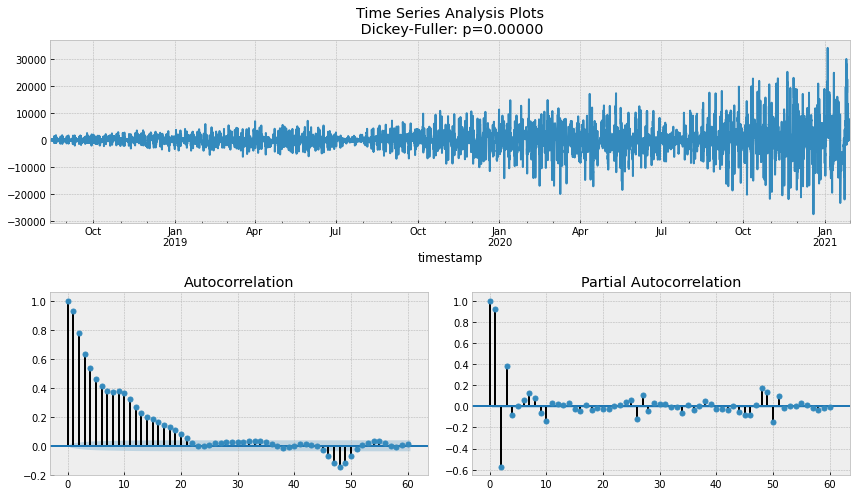

In [11]:
total_diff = totalConsumption - totalConsumption.shift(24)
tsplot(total_diff[24:], lags=60)

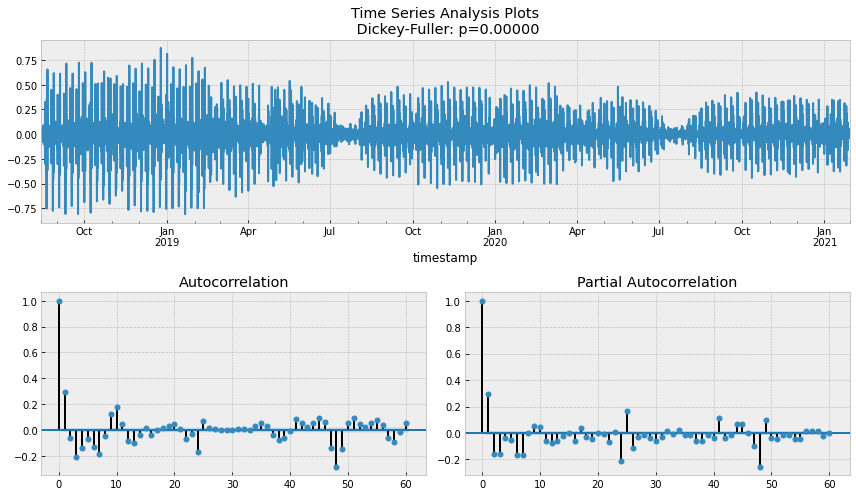

In [12]:
per_diff = per_diff - per_diff.shift(1)
tsplot(per_diff[24+1:], lags=60)

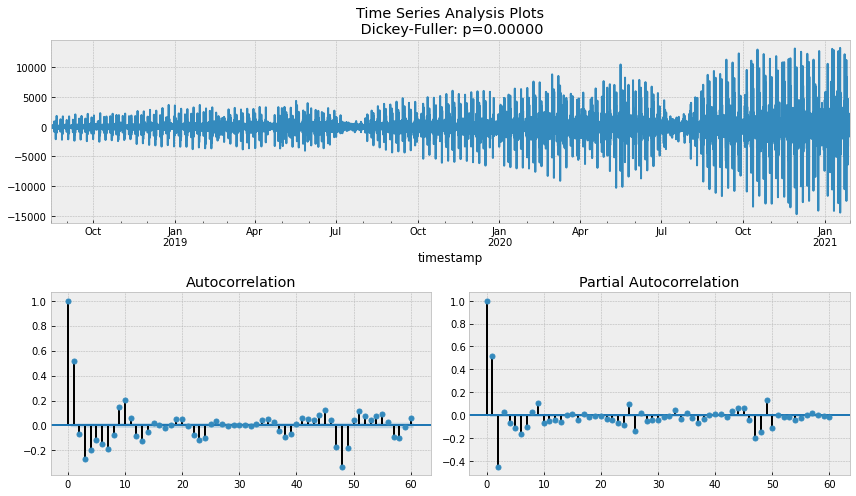

In [13]:
total_diff = total_diff - total_diff.shift(1)
tsplot(total_diff[24+1:], lags=60)

In [14]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  

36

In [63]:
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(per_diff, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [24]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

NameError: ignored

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

In [ ]:
def plotSARIMA(series, model, n_steps):
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [ ]:
plotSARIMA(ads, best_model, 50)